In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
from tempfile import gettempdir

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.geometry import transform_points
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace, average_displacement_error_mean, rmse

from src.utils import load_config, get_model_class
# from src.dataset import load_datasets
from src.trainer import Trainer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\sherh\anaconda3\envs\deep_project\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\sherh\anaconda3\envs\deep_project\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\sherh\anaconda3\envs\deep_project\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sherh\anaconda3\envs\deep_project\lib\site-packages\traitlets\config\application.py", line 1075, in launc

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
# Configurations
CONFIG_PATH = "models/configs/baseline_res50_config.yaml"
MODEL_NAME = "BaselineRes50Model"  # name of model file in models/
EXP_NAME = "notebook_exp_baseline_res50"
EXP_NUM = 1  # which epoch to load for evaluation/vis

# Load config
cfg = load_config(CONFIG_PATH)

In [ ]:
# Paths
exp_dir = os.path.join("experiments", EXP_NAME)
os.makedirs(exp_dir, exist_ok=True)
ckpt_path = os.path.join(exp_dir, f"epoch_{EXP_NUM}.pth")
pred_path = os.path.join(exp_dir, f"predictions_{EXP_NUM}.csv")

In [ ]:
# Load Datasets
# train_loader, val_loader = load_datasets(cfg)
os.environ["L5KIT_DATA_FOLDER"] = "data/small_dataset"
# os.environ["L5KIT_DATA_FOLDER"] = "../data/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=0)
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")

Number of training samples: 111634
Number of training batches: 4652


In [ ]:
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=0)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
# num_frames_to_chop = 100
# eval_cfg = cfg["val_data_loader"]
# zarr_path = Path(dm.require(eval_cfg["key"]))
# eval_base_path = zarr_path.parent / f"{zarr_path.stem}_chopped_{num_frames_to_chop}"

# if not eval_base_path.exists():
#     eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
#                               num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

# eval_zarr_path = str(Path(eval_base_path) / zarr_path.name)
# eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_gt_path = str(Path(eval_base_path) / "gt.csv")

# eval_zarr = ChunkedDataset(eval_zarr_path).open()
# eval_mask = np.load(eval_mask_path)["arr_0"]

# # ===== INIT DATASET AND LOAD MASK
# eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
# eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
#                             num_workers=0)
# print(eval_dataset)

In [ ]:
# Create Model
ModelClass = get_model_class(MODEL_NAME)
model = ModelClass(cfg)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\sherh\anaconda3\envs\deep_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sherh\anaconda3\envs\deep_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


In [ ]:
print(model)
print(list(model.parameters()))
print(sum(p.numel() for p in model.parameters()))

BaselineRes50Model(
  (model): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [ ]:
from src.trainer import Trainer
# Train (only if checkpoint doesn't exist)
losses_train = []
if not os.path.exists(ckpt_path):
    print(f"Checkpoint not found at {ckpt_path}, training model...")
    trainer = Trainer(cfg, model, device, train_dataloader, exp_name=EXP_NAME)
    # losses_train = trainer.train(EXP_NUM)
    losses_train, losses_val_epoch, losses_train_epoch = trainer.train_and_validate(eval_dataloader, EXP_NUM)
else:
    print(f"Loading existing checkpoint: {ckpt_path}")
    model.load_state_dict(torch.load(ckpt_path))

Checkpoint not found at experiments\notebook_exp_baseline_res50\epoch_154.pth, training model...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Starting


loss: 82.94525146484375 loss(avg): 49.903516578674314:   0%|          | 0/5 [00:00<?, ?it/s]        

Epoch 1 | Train Loss: 49.9035 | Val Loss: 82.7959
Epoch 2 - Starting


loss: 48.1796760559082 loss(avg): 65.06296319961548:   0%|          | 0/5 [00:00<?, ?it/s]          

Epoch 2 | Train Loss: 80.2224 | Val Loss: 234.8917
Epoch 3 - Starting


loss: 40.37012481689453 loss(avg): 61.37645905812581:   0%|          | 0/5 [00:00<?, ?it/s]         

Epoch 3 | Train Loss: 54.0035 | Val Loss: 59.8906
Epoch 4 - Starting


loss: 37.84659957885742 loss(avg): 58.623477125167845:   0%|          | 0/5 [00:00<?, ?it/s]         

Epoch 4 | Train Loss: 50.3645 | Val Loss: 73.0831
Epoch 5 - Starting


loss: 37.880184173583984 loss(avg): 52.45424831390381:   0%|          | 0/5 [00:00<?, ?it/s]         

Epoch 5 | Train Loss: 27.7773 | Val Loss: 26.1183
Epoch 6 - Starting


loss: 37.039058685302734 loss(avg): 47.231796423594155:   0%|          | 0/5 [00:00<?, ?it/s]        

Epoch 6 | Train Loss: 21.1195 | Val Loss: 34.9068
Epoch 7 - Starting


loss: 14.532864570617676 loss(avg): 43.87149783543178:   0%|          | 0/5 [00:00<?, ?it/s]         

Epoch 7 | Train Loss: 23.7097 | Val Loss: 61.6071
Epoch 8 - Starting


loss: 90.66558837890625 loss(avg): 45.0781756401062:   0%|          | 0/5 [00:00<?, ?it/s]          

Epoch 8 | Train Loss: 53.5249 | Val Loss: 38.3943
Epoch 9 - Starting


loss: 17.63899803161621 loss(avg): 43.91501873864068:   0%|          | 0/5 [00:00<?, ?it/s]         

Epoch 9 | Train Loss: 34.6098 | Val Loss: 54.7254
Epoch 10 - Starting


loss: 26.836585998535156 loss(avg): 42.96461486816406: 100%|██████████| 5/5 [02:22<00:00, 26.05s/it] 

Epoch 10 | Train Loss: 34.4110 | Val Loss: 141.5169


loss: 26.836585998535156 loss(avg): 42.96461486816406: 100%|██████████| 5/5 [02:35<00:00, 31.11s/it]


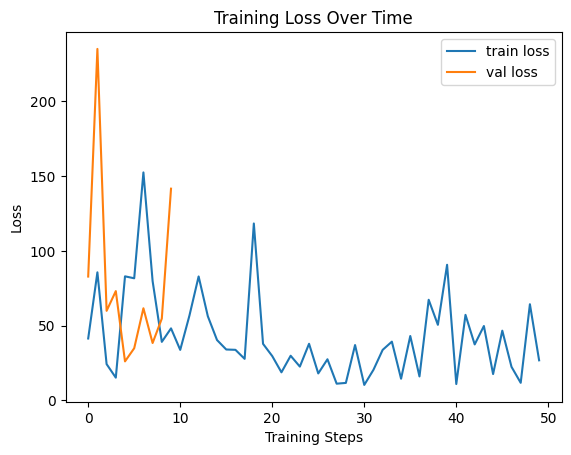

In [ ]:
if losses_train:
    plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.show()

In [ ]:
if losses_train_epoch:
    plt.plot(np.arange(len(losses_train_epoch)), losses_train_epoch, label="train loss (epoch)")
    plt.plot(np.arange(len(losses_train_epoch)), losses_val_epoch, label="val loss (epoch)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

In [ ]:
# save losses as npy file
losses_train_path = os.path.join(exp_dir, f"losses_train_{EXP_NUM}.npy")
losses_train_epoch_path = os.path.join(exp_dir, f"losses_train_epoch_{EXP_NUM}.npy")
losses_val_epoch_path = os.path.join(exp_dir, f"losses_val_{EXP_NUM}.npy")

np.save(losses_train_path, losses_train)
np.save(losses_train_epoch_path, losses_train_epoch)
np.save(losses_val_epoch_path, losses_val_epoch)

NameError: name 'losses_train_epoch' is not defined

In [ ]:
# load the npy files
# losses_train = np.load("losses_train.npy")
# losses_val = np.load("losses_val.npy")

In [ ]:
# ===== GENERATE AND LOAD CHOPPED TEST DATASET
num_frames_to_chop = 100
test_cfg = cfg["test_data_loader"]
test_base_path = create_chopped_dataset(dm.require(test_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"],
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

C:\Users\sherh\OneDrive - Technion\Documents\Master\Semester4\Deep Learning\Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\data\zarr_utils.py:244: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]
C:\Users\sherh\OneDrive - Technion\Documents\Master\Semester4\Deep Learning\Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\evaluation\extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:07<00:00, 66.10it/s]


In [ ]:
test_zarr_path = str(Path(test_base_path) / Path(dm.require(test_cfg["key"])).name)
test_mask_path = str(Path(test_base_path) / "mask.npz")
test_gt_path = str(Path(test_base_path) / "gt.csv")

test_zarr = ChunkedDataset(test_zarr_path).open()
test_mask = np.load(test_mask_path)["arr_0"]
# ===== INIT TEST DATASET AND LOAD MASK
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset, shuffle=test_cfg["shuffle"], batch_size=test_cfg["batch_size"], 
                             num_workers=0)
print(test_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


C:\Users\sherh\AppData\Local\Temp\ipykernel_5912\1746033959.py:8: RuntimeWarning: you're running with a custom agents_mask
  test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)


In [ ]:
# Evaluate
# ==== EVAL LOOP
def evaluate_model(model, test_dataloader, device, pred_path):
    model.eval()
    criterion = nn.MSELoss(reduction="none")

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    agent_ids = []

    progress_bar = tqdm(test_dataloader)
    with torch.no_grad():
        for data in progress_bar:
            loss, outputs = model.forward_pass(data, device, criterion)

            # print(f"Loss: {loss.item():.4f}")

            # convert agent coordinates into world offsets
            agents_coords = outputs.cpu().numpy()
            world_from_agents = data["world_from_agent"].numpy()
            centroids = data["centroid"].numpy()
            coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
            
            future_coords_offsets_pd.append(np.stack(coords_offset))
            timestamps.append(data["timestamp"].numpy().copy())
            agent_ids.append(data["track_id"].numpy().copy())
    
    write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
# Evaluation (only if prediction doesn't exist)
if not os.path.exists(pred_path):
    print(f"Predictions not found at {pred_path}, evaluating model...")
    evaluate_model(model, test_dataloader, device, pred_path)
else:
    print(f"Loading existing predictions: {pred_path}")

Predictions not found at experiments\notebook_exp_baseline_res50\predictions_154.csv, evaluating model...


  5%|▌         | 1/20 [00:11<03:36, 11.39s/it]

Loss: 0.0000


 10%|█         | 2/20 [00:24<03:48, 12.69s/it]

Loss: 0.0000


 15%|█▌        | 3/20 [00:34<03:10, 11.18s/it]

Loss: 0.0000


 20%|██        | 4/20 [00:43<02:48, 10.51s/it]

Loss: 0.0000


 25%|██▌       | 5/20 [00:52<02:25,  9.71s/it]

Loss: 0.0000


 30%|███       | 6/20 [01:01<02:13,  9.56s/it]

Loss: 0.0000


 35%|███▌      | 7/20 [01:10<02:03,  9.47s/it]

Loss: 0.0000


 40%|████      | 8/20 [01:21<02:00, 10.02s/it]

Loss: 0.0000


 45%|████▌     | 9/20 [01:31<01:47,  9.75s/it]

Loss: 0.0000


 50%|█████     | 10/20 [01:40<01:36,  9.64s/it]

Loss: 0.0000


 55%|█████▌    | 11/20 [01:51<01:29,  9.97s/it]

Loss: 0.0000


 60%|██████    | 12/20 [02:00<01:17,  9.68s/it]

Loss: 0.0000


 65%|██████▌   | 13/20 [02:08<01:05,  9.39s/it]

Loss: 0.0000


 70%|███████   | 14/20 [02:18<00:56,  9.40s/it]

Loss: 0.0000


 75%|███████▌  | 15/20 [02:30<00:51, 10.20s/it]

Loss: 0.0000


 80%|████████  | 16/20 [02:42<00:43, 10.75s/it]

Loss: 0.0000


 85%|████████▌ | 17/20 [02:50<00:29,  9.98s/it]

Loss: 0.0000


 90%|█████████ | 18/20 [02:57<00:18,  9.13s/it]

Loss: 0.0000


 95%|█████████▌| 19/20 [03:04<00:08,  8.47s/it]

Loss: 0.0000


100%|██████████| 20/20 [03:13<00:00,  9.67s/it]


Loss: 0.0000


100%|██████████| 480/480 [00:00<00:00, 727.26it/s]


In [ ]:
metrics = compute_metrics_csv(test_gt_path, pred_path, [neg_multi_log_likelihood, time_displace, average_displacement_error_mean, rmse])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

# save metrics as csv without pandas
with open(os.path.join(exp_dir, f"metrics_{EXP_NUM}.csv"), "w") as f:
    f.write("metric,mean\n")
    for metric_name, metric_mean in metrics.items():
        f.write(f"{metric_name},{metric_mean}\n")

100%|██████████| 480/480 [00:00<00:00, 624.51it/s]

neg_multi_log_likelihood 7410.322526563487
time_displace [ 0.46637497  1.39114953  0.36891562  0.60154782  1.61619067  2.6845224
  3.54237054  3.77678975  4.28793533  4.53517272  4.79355158  5.19714129
  5.79993367  6.37299128  6.82730428  7.43261315  7.80246848  8.10103236
  8.30399619  8.65019029  8.53950796  8.82568952  8.79969685  9.05004339
  9.23182823  9.43296347  9.71344575  9.50298397  9.98485229  9.47934393
 10.1274422   9.78075964 10.01380514 10.13179163 10.52845348 10.59733244
 10.79110665 11.06960057 10.56919095 10.62830091 11.06634517 11.15054146
 11.1120206  11.23138988 11.20256758 11.19120973 10.36630321 10.24263452
  9.79729537  9.97094878]


In [ ]:
# model.eval()
# torch.set_grad_enabled(False)

# # build a dict to retrieve future trajectories from GT
# gt_rows = {}
# for row in read_gt_csv(eval_gt_path):
#     gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

# eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

# for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
#     agent_indices = eval_dataset.get_frame_indices(frame_number) 
#     if not len(agent_indices):
#         continue

#     # get AV point-of-view frame
#     data_ego = eval_ego_dataset[frame_number]
#     im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
#     center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
#     predicted_positions = []
#     target_positions = []

#     for v_index in agent_indices:
#         print(f"Processing agent {v_index} in frame {frame_number}")
#         data_agent = eval_dataset[v_index]

#         out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
#         out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
#         # store absolute world coordinates
#         predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
#         # retrieve target positions from the GT and store as absolute coordinates
#         track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
#         target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


#     # convert coordinates to AV point-of-view so we can draw them
#     predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
#     target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

#     draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
#     draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

#     plt.imshow(im_ego)
#     plt.show()

In [ ]:
# # Visualization (single example)
# batch = next(iter(eval_dataloader))
# with torch.no_grad():
#     preds = model(batch["image"])

# # Pick first mode of predictions
# preds = preds[:, 0, :].view(-1, cfg["model_params"]["future_num_frames"], 2).cpu().numpy()
# gt = batch["target_positions"].cpu().numpy()

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(batch["image"][0].permute(1, 2, 0).cpu().numpy())
# draw_trajectory(gt[0], ax, color="g", origin=(0, 0))  # Ground truth
# draw_trajectory(preds[0], ax, color="r", origin=(0, 0))  # Prediction
# ax.set_title("Green = GT, Red = Prediction")
# plt.show()

In [ ]:
# batch = next(iter(val_loader))
# preds = model(batch["image"])
# preds = preds[:, 0, :].view(-1, cfg["model_params"]["future_num_frames"], 2).detach().numpy()

# fig, ax = plt.subplots(figsize=(8, 8))
# img = batch["image"][0].permute(1, 2, 0).numpy()
# ax.imshow(img)

# # Draw predicted trajectory (red) & ground truth (green)
# draw_trajectory(preds[0], ax, color="r", origin=(0, 0))
# draw_trajectory(batch["target_positions"][0].numpy(), ax, color="g", origin=(0, 0))
# plt.show()